In [1]:
import os
import polars as pl
import matplotlib.pyplot as plt

## Data reading

- Load all 2024 months of taxi rides  

- Also load taxi zone lookup data  

- Include only rides starting in 2024 and ending at most at 01.01.2025  

- Optimize data types, particularly for integers and categorical strings  


In [2]:
DATA_DIR = "data"  

dfs = []
for month in range(1, 13):
    df = (
        pl.scan_parquet(f"{DATA_DIR}/{month}.parquet")
        .with_columns(
            pl.col("tpep_pickup_datetime").dt.cast_time_unit("ms"),
            pl.col("tpep_dropoff_datetime").dt.cast_time_unit("ms"),
        )
        .filter(
            pl.col("tpep_pickup_datetime").dt.year() == 2024,
            pl.col("tpep_dropoff_datetime") < pl.datetime(2025, 1, 1, time_unit="ms"),
        )
    )
    dfs.append(df)

df_2024 = pl.concat(dfs)

In [3]:



zones = pl.scan_csv("data/taxi_zone_lookup.csv")



In [4]:
df_2024 = df_2024.with_columns(
    pl.col("VendorID").cast(pl.Int8),
    pl.col("passenger_count").cast(pl.Int8),
    pl.col("RatecodeID").cast(pl.Int8),
    pl.col("PULocationID").cast(pl.Int16),
    pl.col("DOLocationID").cast(pl.Int16),
    pl.col("payment_type").cast(pl.Int8),
    pl.col("store_and_fwd_flag").cast(pl.Categorical),
    pl.col("fare_amount").cast(pl.Float32),
    pl.col("extra").cast(pl.Float32),
    pl.col("mta_tax").cast(pl.Float32),
    pl.col("tip_amount").cast(pl.Float32),
    pl.col("tolls_amount").cast(pl.Float32),
    pl.col("improvement_surcharge").cast(pl.Float32),
    pl.col("total_amount").cast(pl.Float32),
    pl.col("congestion_surcharge").cast(pl.Float32),
    pl.col("Airport_fee").cast(pl.Float32),
    pl.col("trip_distance").cast(pl.Float32),
)

## Data cleaning and filtering 


- Fill NULL values in `passengers_count` with 1
- Remove rides with zero passengers
- If a ride has over 6 passengers, replace the value with 6
- Remove rides lasting over 2 hours
- In all money-related columns, replace values with absolute value to fix negative amounts
- Remove rides with over 1000 dollars in any money-related column
- Remove rows with values of `RatecodeID` or `VendorID` missing or outside those defined in the data dictionary


In [ ]:
MN_COLS = [
    "fare_amount",
    "extra",
    "mta_tax",
    "tip_amount",
    "tolls_amount",
    "improvement_surcharge",
    "congestion_surcharge",
    "Airport_fee",
    "total_amount",
]

POSSIBLE_VENDOR = [1, 2]
POSSIBLE_RATE   = [1, 2, 3, 4, 5, 6]

df_clean = (
    df_2024
    .with_columns( pl.col("passenger_count").fill_null(1).alias("passenger_count"))
    .filter(pl.col("passenger_count") != 0)
    .with_columns( pl.when(pl.col("passenger_count") > 6).then(6).otherwise(pl.col("passenger_count")).alias("passenger_count"))

    .with_columns(
        ((pl.col("tpep_dropoff_datetime") - pl.col("tpep_pickup_datetime")) / pl.duration(minutes=1)).alias("trip_minutes")
    )

    .filter( pl.col("trip_minutes").is_not_null() &(pl.col("trip_minutes") > 0) &(pl.col("trip_minutes") <= 120) )

    .with_columns([pl.col(c).abs().alias(c) for c in MN_COLS])

    .with_columns(pl.max_horizontal([pl.col(c).fill_null(0) for c in MN_COLS]).alias("max_money"))

    .filter(pl.col("max_money") <= 1000).drop("max_money")

    .filter(
        pl.col("VendorID").is_in(POSSIBLE_VENDOR) & pl.col("VendorID").is_not_null() &
        pl.col("RatecodeID").is_in(POSSIBLE_RATE) & pl.col("RatecodeID").is_not_null()
    )

    .drop("trip_minutes")
)

## 3. Data transformation

- Combine payment type values for `"No charge"`, `"Dispute"`, `"Unknown"` and `"Voided trip"` into one type, so we have only credit card, cash, or other
- Replace `PULocationID` and `DOLocationID` with borough names by joining taxi zone lookup and removing unnecessary columns
- Add boolean variable `is_airport_ride`, true if there is non-zero airport fee
- Add boolean variable `is_rush_hour`, rush hours are defined as 6:30–9:30 and 15:30–20:00 during weekdays


In [20]:
zones_lf = pl.scan_csv("data/taxi_zone_lookup.csv").select(["LocationID", "Borough"])
zones_pu = zones_lf.rename({"Borough": "pu_borough"})
zones_do = zones_lf.rename({"Borough": "do_borough"})

ts_morning = pl.time(6, 30)
te_morning = pl.time(9, 30)
ts_evening = pl.time(15, 30)
te_evening = pl.time(20, 0)

df_transformed = (
    df_clean
    .join(zones_pu, left_on="PULocationID", right_on="LocationID")
    .join(zones_do, left_on="DOLocationID", right_on="LocationID", suffix="_do")
    .drop(["LocationID", "LocationID_do"], strict=False)
    .with_columns([
        (pl.col("Airport_fee").fill_null(0) > 0).alias("is_airport_ride"),
        (
            (pl.col("tpep_pickup_datetime").dt.weekday() <= 4) &
            (
                pl.col("tpep_pickup_datetime").dt.time().is_between(ts_morning, te_morning, closed="left") |
                pl.col("tpep_pickup_datetime").dt.time().is_between(ts_evening, te_evening, closed="left")
            )
        )
        .cast(pl.Int8)  
        .alias("is_rush_hour"),
    ])
)

## 4. Feature extraction

- Apply dummy encoding to features:
  - payment type
  - pickup borough
  - dropoff borough

- Add integer variables for counting daily events:
  - total number of rides (target variable)
  - number of airport rides
  - number of rush hour rides

- Add features aggregating daily rides information:
  - average fare amount
  - median distance
  - sum of total amounts
  - total amount paid by card, cash, and other
  - total congestion surcharge
  - total number of passengers

- Add time features:
  - `quarter`
  - `month`
  - `day_of_month`
  - `day_of_week`
  - `is_weekend` (boolean)

- Add column `date`, indicating day with given features
- Make sure to exclude other columns unnecessary for machine learning (IDs, timestamps, unused financial information)
- Properly name all columns
- Save results as `dataset.parquet` file

In [ ]:
df_src = df_transformed.select(pl.all())  

daily_df = (
    df_src.with_columns(date = pl.col("tpep_pickup_datetime").dt.date()).group_by("date")
    .agg(
        n_rides  = pl.len(),
        n_airport = pl.col("is_airport_ride").sum(),
        n_rush_hour = pl.col("is_rush_hour").sum(),
        fare_mean = pl.col("fare_amount").mean(),
        dist_median = pl.col("trip_distance").median(),
        total_amount_sum = pl.col("total_amount").sum(),
        congestion_sum = pl.col("congestion_surcharge").sum(),
        passengers_sum = pl.col("passenger_count").sum(),
    )
    .with_columns(
        quarter = pl.col("date").dt.quarter(),
        month = pl.col("date").dt.month(),
        day_of_month = pl.col("date").dt.day(),
        day_of_week = pl.col("date").dt.weekday(),
        is_weekend = (pl.col("date").dt.weekday() >= 5),
    )
    .sort("date")
)

result = daily_df.collect()
result.write_parquet("dataset.parquet")

## 5. Data analysis

- Print shape
- Show top rows
- Describe statistics
- Print schema

- Plot target variable (daily number of rides):
  - Histogram of values
  - Line plot: date vs number of rides (remember to sort by date)

In [23]:

df= pl.read_parquet("dataset.parquet")



In [24]:
print(f"shape {df.shape}")
print(f"Top rows {df.head(5)}")


shape (366, 14)
Top rows shape: (5, 14)
┌────────────┬─────────┬───────────┬────────────┬───┬───────┬────────────┬────────────┬────────────┐
│ date       ┆ n_rides ┆ n_airport ┆ n_rush_hou ┆ … ┆ month ┆ day_of_mon ┆ day_of_wee ┆ is_weekend │
│ ---        ┆ ---     ┆ ---       ┆ r          ┆   ┆ ---   ┆ th         ┆ k          ┆ ---        │
│ date       ┆ u32     ┆ u32       ┆ ---        ┆   ┆ i8    ┆ ---        ┆ ---        ┆ bool       │
│            ┆         ┆           ┆ i64        ┆   ┆       ┆ i8         ┆ i8         ┆            │
╞════════════╪═════════╪═══════════╪════════════╪═══╪═══════╪════════════╪════════════╪════════════╡
│ 2024-01-01 ┆ 69523   ┆ 8350      ┆ 19354      ┆ … ┆ 1     ┆ 1          ┆ 1          ┆ false      │
│ 2024-01-02 ┆ 71428   ┆ 9828      ┆ 30541      ┆ … ┆ 1     ┆ 2          ┆ 2          ┆ false      │
│ 2024-01-03 ┆ 78378   ┆ 9137      ┆ 32908      ┆ … ┆ 1     ┆ 3          ┆ 3          ┆ false      │
│ 2024-01-04 ┆ 97876   ┆ 8265      ┆ 43104      ┆ …

In [25]:
print(df.describe())


shape: (9, 15)
┌───────────┬───────────┬───────────┬───────────┬───┬──────────┬───────────┬───────────┬───────────┐
│ statistic ┆ date      ┆ n_rides   ┆ n_airport ┆ … ┆ month    ┆ day_of_mo ┆ day_of_we ┆ is_weeken │
│ ---       ┆ ---       ┆ ---       ┆ ---       ┆   ┆ ---      ┆ nth       ┆ ek        ┆ d         │
│ str       ┆ str       ┆ f64       ┆ f64       ┆   ┆ f64      ┆ ---       ┆ ---       ┆ ---       │
│           ┆           ┆           ┆           ┆   ┆          ┆ f64       ┆ f64       ┆ f64       │
╞═══════════╪═══════════╪═══════════╪═══════════╪═══╪══════════╪═══════════╪═══════════╪═══════════╡
│ count     ┆ 366       ┆ 366.0     ┆ 366.0     ┆ … ┆ 366.0    ┆ 366.0     ┆ 366.0     ┆ 366.0     │
│ null_coun ┆ 0         ┆ 0.0       ┆ 0.0       ┆ … ┆ 0.0      ┆ 0.0       ┆ 0.0       ┆ 0.0       │
│ t         ┆           ┆           ┆           ┆   ┆          ┆           ┆           ┆           │
│ mean      ┆ 2024-07-0 ┆ 98842.956 ┆ 8975.5437 ┆ … ┆ 6.513661 ┆ 15.756831 ┆

In [26]:
print(df.schema)

Schema([('date', Date), ('n_rides', UInt32), ('n_airport', UInt32), ('n_rush_hour', Int64), ('fare_mean', Float32), ('dist_median', Float32), ('total_amount_sum', Float32), ('congestion_sum', Float32), ('passengers_sum', Int64), ('quarter', Int8), ('month', Int8), ('day_of_month', Int8), ('day_of_week', Int8), ('is_weekend', Boolean)])


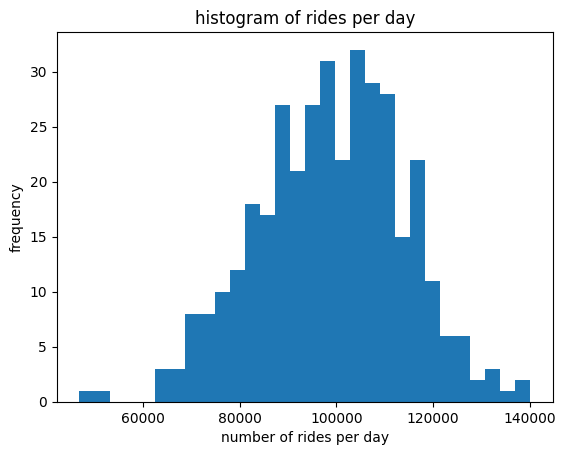

In [29]:
y = "n_rides" if "n_rides" in df.columns else "total_rides"

plt.hist(df[y], bins=30)
plt.xlabel("number of rides per day")
plt.ylabel("frequency")
plt.title("histogram of rides per day")
plt.show()



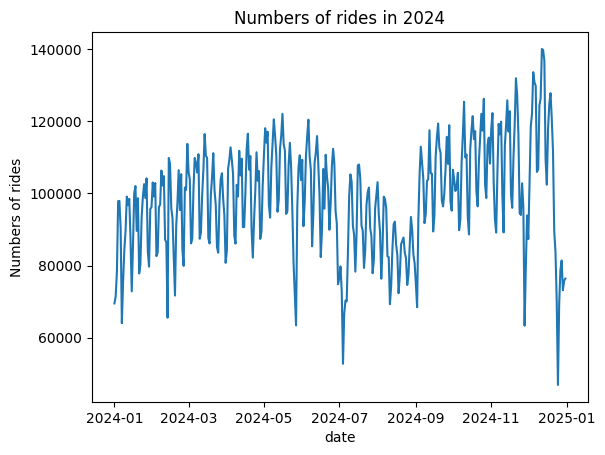

In [31]:

plt.plot(df["date"], df[y])
plt.title("Numbers of rides in 2024")
plt.xlabel("date")
plt.ylabel("Numbers of rides")
plt.show()

